# Week 2: Table Manipulations and Environmental Justice
The **objective** of this lecture is to apply the `groupby()`, `merge()`, and row-filtering from the previous lecture to an application in environmental justice.

## Application
The EJSCREEN indices are used to prioritize federal funding in order to mitigate environmental injustice. Here, we examine the rural and urban representation in the prioritization data. Does this reflect the composition of the United States?  

First, read in a dataset that associates each U.S. county with a CDC assessment of urban/suburban/rural. The counties are uniquely identified by a Federal Information Processing System (FIPS) Code. 

In [2]:
import pandas

In [3]:
# Source: https://www.cdc.gov/nchs/data_access/urban_rural.htm#Data_Files_and_Documentation
nchs = pandas.read_excel("https://github.com/danhammer/envirods/blob/main/data/NCHSURCodes2013.xlsx?raw=true")
nchs = nchs[["FIPS code", "State Abr.", "County name", "2013 code"]]
nchs.columns = ["fips", "state", "county", "classification"]

In [4]:
# Associate each of the classifications to one of three categories, rather 
# than one of six - just to simplify our quick analysis
remap_dict = {
    1: "urban",
    2: "suburban",
    3: "suburban",
    4: "rural",
    5: "rural",
    6: "rural"
}

# replace the values of the `classification` column based on the key-value 
# pair in `remap_dict`
nchs = nchs.replace({'classification': remap_dict})

Now, read in the EJ indices and merge the dataset with the urban/suburban/rural dataset, so that each of the Census Blocks in the EJSCREEN data now has the CDC categorization.

In [5]:
ejdf = pandas.read_csv("https://raw.githubusercontent.com/danhammer/envirods/main/data/EJSCREEN_demo2.csv")
ejdf = ejdf.merge(nchs, how='left', on='fips')

In [6]:
# A dictionary to translate opaque variable names to somthing that
# is human-readable
ejvars_dict = {
    'P_LDPNT_D2': 'Lead Paint',
    'P_DSLPM_D2': 'Diesel Particulate Matter',
    'P_CANCR_D2': 'Air Toxics Cancer Risk',
    'P_RESP_D2':  'Respiratory Hazard',
    'P_PTRAF_D2': 'Traffic Proximity',
    'P_PWDIS_D2': 'Water Discharge',
    'P_PNPL_D2':  'National Priority List',
    'P_PRMP_D2':  'Risk Management Plan',
    'P_PTSDF_D2': 'Treatment Storage and Disposal',
    'P_OZONE_D2': 'Ozone Proximity',
    'P_PM25_D2':  'PM25'
}

Each of the variables in the dataset indicates the percentile where that Census Block falls in prioritization. Those census blocks with high percentiles are prioritized for federal funding.  Here, we examine the urban/suburban/rural breakdown of the population living within these high-priority Census Blocks.

In [7]:
v = 'P_LDPNT_D2'
temp_df = ejdf[ejdf[v] > 90]
temp_df = temp_df.groupby('classification').sum()['ACSTOTPOP']

# add back in the classification variable for future reference
temp_dict = dict(temp_df)
temp_dict['classification'] = v
temp_dict

{'rural': 2159353,
 'suburban': 8769330,
 'urban': 21362290,
 'classification': 'P_LDPNT_D2'}

In [8]:
# Instead of just displaying the results for one variable, collect 
# the results for all in a list.
res = []

# Note that ejvars_dict.keys() is a list of the EJ variable names
for v in ejvars_dict.keys():
    temp_df = ejdf[ejdf[v] > 90]
    temp_df = temp_df.groupby('classification').sum()['ACSTOTPOP']
    temp_dict = dict(temp_df)
    temp_dict['classification'] = v
    res.append(temp_dict)

# Create a dataframe of the results
graphing_df = pandas.DataFrame(res)
graphing_df

,rural,suburban,urban,classification
0,2159353,8769330,21362290,P_LDPNT_D2
1,358539,8593184,23329310,P_DSLPM_D2
2,2116580,11012158,19152297,P_CANCR_D2
3,2076324,10708628,19495515,P_RESP_D2
4,491038,8866869,22933011,P_PTRAF_D2
5,3829551,11166090,17275490,P_PWDIS_D2
6,1580116,10192692,20513568,P_PNPL_D2
7,2231688,11590671,18468443,P_PRMP_D2
8,426142,6697207,25167032,P_PTSDF_D2
9,2416940,11462835,18195082,P_OZONE_D2


We now have a dataframe with the total population in rural, suburban, and urban areas that would be prioritized for EJ funding for each of the 11 indicators.  Now, convert this into a percentage, noting that we can't just divide by the total population of the United States across all of these cell values due to missing values - and the fact that those missing values aren't uniformly distributed across the indicators.

In [10]:
pop_df = graphing_df[["rural", "suburban", "urban"]]

# first sum over the columns, horizontally
total_by_class = pop_df.sum(axis="columns")

# then divide, within columns, vertically
pop_df = pop_df.div(total_by_class, axis="index")

# add back the classification
pop_df["classification"] = graphing_df["classification"]

# name it appropriately
pop_df["indicators"] = pop_df.classification.replace(ejvars_dict)

pop_df

,rural,suburban,urban,classification,indicators
0,0.066872,0.271572,0.661556,P_LDPNT_D2,Lead Paint
1,0.011107,0.266199,0.722694,P_DSLPM_D2,Diesel Particulate Matter
2,0.065567,0.341134,0.593299,P_CANCR_D2,Air Toxics Cancer Risk
3,0.064321,0.331737,0.603942,P_RESP_D2,Respiratory Hazard
4,0.015207,0.274593,0.710200,P_PTRAF_D2,Traffic Proximity
5,0.118668,0.346009,0.535323,P_PWDIS_D2,Water Discharge
6,0.048941,0.315696,0.635363,P_PNPL_D2,National Priority List
7,0.069112,0.358947,0.571941,P_PRMP_D2,Risk Management Plan
8,0.013197,0.207406,0.779397,P_PTSDF_D2,Treatment Storage and Disposal
9,0.075353,0.357378,0.567269,P_OZONE_D2,Ozone Proximity


<AxesSubplot:ylabel='indicators'>

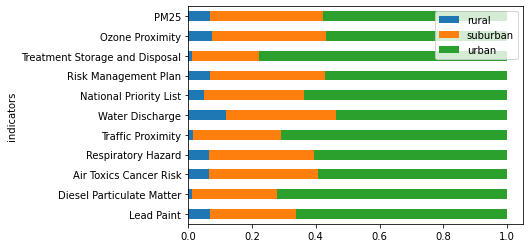

In [11]:
# Plot the results. 
pop_df = pop_df.set_index(pop_df.indicators)

pop_df.plot(
    kind="barh", 
    stacked=True
)

<AxesSubplot:ylabel='indicators'>

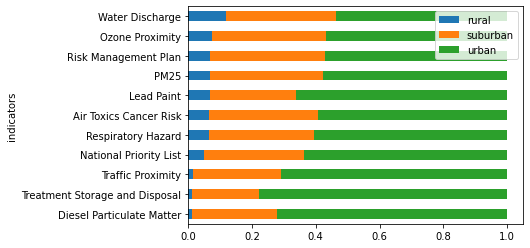

In [12]:
pop_df.sort_values(by=['rural']).plot(
    kind="barh", 
    stacked=True
)

Does this plot reflect the composition rest of the country?  **No.**

In [14]:
ejdf.groupby("classification").sum()["ACSTOTPOP"] / sum(ejdf["ACSTOTPOP"])

classification
rural       0.231544
suburban    0.453165
urban       0.304910
Name: ACSTOTPOP, dtype: float64

Should it?  I don't know.  But this very apparent mismatch is not being adequately addressed at the highest levels of government, as they discuss how to identify "underserved communities."

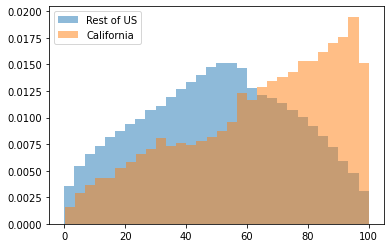

         P_LDPNT_D2    P_DSLPM_D2    P_CANCR_D2     P_RESP_D2    P_PTRAF_D2  \
count  23212.000000  23176.000000  23176.000000  23176.000000  22778.000000   
mean      63.997477     63.675654     63.914887     63.693009     61.928700   
std       27.108648     23.043117     24.156415     25.651955     33.849999   
min        0.010049      0.266462      0.326132      0.156210      0.015279   
25%       44.326019     47.497393     47.018694     44.866301     29.270932   
50%       69.090515     67.256184     67.650239     68.556449     75.258019   
75%       86.867057     82.417747     84.130829     85.484945     91.693704   
max       99.990475     99.966286     99.922428     99.995233    100.000000   

         P_PWDIS_D2     P_PNPL_D2     P_PRMP_D2    P_PTSDF_D2    P_OZONE_D2  \
count  11040.000000  23212.000000  23212.000000  23212.000000  23195.000000   
mean      64.602714     64.148103     63.653834     61.727055     64.961666   
std       35.120342     25.776096     26.673066    

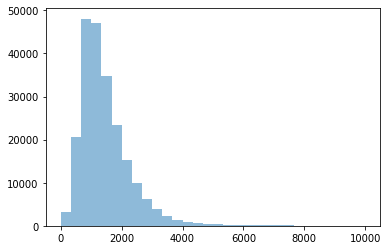

In [51]:
220000 - ejdf.describe()[0:1]
ejdf.isnull().sum()
ca = ejdf[ejdf.state == "CA"]
rest_of_usa = ejdf[ejdf.state != "CA"]

import matplotlib.pyplot as plt
# plotting histograms

plt.hist(
    rest_of_usa['P_RESP_D2'], 
    label="Rest of US",
    density=True,
    bins=30,
    alpha = 0.5
)
plt.hist(
    ca['P_RESP_D2'], 
    label='California',
    density=True,
    bins=30,
    alpha = 0.5
)
  
plt.legend(loc='upper left')

plt.show()

print(ca.describe())

plt.hist(
    ejdf['ACSTOTPOP'], 
    bins=30,
    alpha = 0.5,
    range=[0, 10000]
)

plt.show()
  


# Lab 2

1. Using the dataset from Week 2 `EJSCREEN_demo2.csv`, create a table with the number of missing values for every environmental justice score in the dataset (e.g., `P_RESP_D2`).  Comment on why some of the variables may have more missing values than others. 

2. What is the average population represented by a Census Block Group.  Plot a histogram for all Census Block Groups with populations less than 10,000.  

3. How many Census Block Groups are there in California (referring to this particular dataset)?  How does the average score of "Respiratory Hazard" in California Block Groups compare to the rest of the country? Does this make sense to you?

4. Create single plot with **two** overlaid histograms. Plot the *density* of block groups at different respiratory hazard scores (0-100) for California and for the rest of the United States. (Hint: a parameter `density=True` should be set). The  One for California respiratory hazard.  Make this look nice by adding a legend and making sure that the histograms are not totally opaque. (Hint: set the parameter `alpha` to be less than 1.)  Comment on the skewness of the distributions.